In [441]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [442]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test_temp = test

In [443]:
def clean1(df):
    df["Age"] = round(df["Age"])
    
    Title = []
    for name in df["Name"]:
        if "Mr." in name:
            Title.append("Mr.")
        elif "Mrs." in name:
            Title.append("Mrs.")
        elif "Miss." in name:
            Title.append("Miss.")
        elif "Master." in name:
            Title.append("Master.")
        else:
            Title.append("")
    df["Title"] = Title
    
    df = df.drop(columns = ["PassengerId", "Name"])
    # Alternatively, 
    # df = df.drop(["PassengerId", "Name"], axis = 1)
    # del df["PassengerId"], df["Name"]
    
    if "Survived" in df.columns:
        cols_at_end = ["Survived"]
        df = df[[c for c in df if c not in cols_at_end] + [c for c in cols_at_end if c in df]]
        
    df = df.replace("", np.nan, regex = True)
    
    return df

train = clean1(train)
test = clean1(test)

In [444]:
def clean2(df):
    df = df.drop(columns = ["Cabin"])
    
    ticket_encoding = LabelEncoder()
    df.loc[:, "Ticket"] = ticket_encoding.fit_transform(df.loc[:, "Ticket"])
    
    return df

train = clean2(train)
test = clean2(test)

In [445]:
pd.crosstab(train["Title"], train["Sex"], margins = False)

Sex,female,male
Title,,
Master.,0,69
Miss.,312,0
Mr.,0,1506
Mrs.,263,0


In [446]:
def clean3(df):
    frame = df[pd.isnull(df["Title"]) & (df["Sex"]=="male")]
    indices = list(frame.index)
    for index in indices:
        if df.loc[index, "Age"] <= 10:
            df.loc[index, "Title"] = "Master."
        else:
            df.loc[index, "Title"] = "Mr."
    
    frame = df[pd.isnull(df["Title"]) & (df["Sex"]=="female")]
    indices = list(frame.index)
    for index in indices:
        if df.loc[index, "Age"] < 30:
            df.loc[index, "Title"] = "Miss."
        else:
            df.loc[index, "Title"] = "Mrs."
            
    return df

train = clean3(train)
test = clean3(test)

In [447]:
def clean4(df, col):
    frame = df[pd.isnull(df[col]) & pd.notnull(df["Title"]) & pd.notnull(df["Pclass"])]
    indices = list(frame.index)
    MyTitles = ["Mr.", "Master.", "Mrs.", "Miss."]
    MyPclass = [1, 2, 3]
    MyList = []
    
    for i in range(len(MyTitles)):
        for j in range(len(MyPclass)):
            MyData = df[(df["Title"] == MyTitles[i]) & (df["Pclass"] == MyPclass[j])][col]
            MyList.append(np.nanmedian(MyData))  
    
    for index in indices:
        if pd.notnull(df["Title"][index]) & pd.notnull(df["Pclass"][index]):
            temp = [df["Title"][index], df["Pclass"][index]]
            index1 = MyTitles.index(temp[0])
            index2 = MyPclass.index(temp[1])
            df.loc[index, col] = MyList[index1*len(MyPclass) + index2]
            
    return df

train = clean4(train, "Age")
test = clean4(test, "Age")

In [448]:
train = clean4(train, "Fare")
test = clean4(test, "Fare")

In [449]:
indices = list(train[pd.isnull(train["Embarked"])].index)
train.loc[indices,"Embarked"] = "C"

In [450]:
def clean5(df):
    df["Sex"] = df["Sex"].map({"male": 1, "female": 0})
    df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})
    df["Title"] = df["Title"].map({"Master.": 0, "Miss.": 1, "Mr.": 2, "Mrs.": 3})

    # df["Sex"].replace({"female": 0, "male": 1}, inplace=True)
    # df["Embarked"].replace({"C": 0, "Q": 1, "S": 2}, inplace=True)
    # df["Title"].replace({"Master.": 0, "Miss.": 1, "Mr.": 2, "Mrs.": 3}, inplace=True)
    
    # sex_encoding = LabelEncoder()
    # df.loc[:, "Sex"] = sex_encoding.fit_transform(df.loc[:, "Sex"])
    # embarked_encoding = LabelEncoder()
    # df.loc[:, "Embarked"] = sex_encoding.fit_transform(df.loc[:, "Embarked"])
    # Title_encoding = LabelEncoder()
    # df.loc[:, "Title"] = sex_encoding.fit_transform(df.loc[:, "Title"])
    
    return df
    
train = clean5(train)
test = clean5(test)

In [451]:
def ModelAccuracy(model):
    pred_train, pred_test, tar_train, tar_test = train_test_split(train[list(test.columns)], train["Survived"], test_size = 0.2)
    
    if model == "NaiveBayes":
        classifier = GaussianNB()
    elif model == "RandomForest":
        classifier = RandomForestClassifier(n_estimators = 100)
    elif model == "DecisionTree":
        classifier = DecisionTreeClassifier(random_state = 100)
    elif model == "XGBoost":
        classifier = XGBClassifier()
    elif model == "LogisticRegression":
        classifier = LogisticRegression(solver = "lbfgs", max_iter = 700)
    elif model == "SVM":
        classifier = SVC(gamma = "scale")
    elif model == "KNeighborsClassifier":
        classifier = KNeighborsClassifier(p = 2, n_neighbors = 10)
    elif model == "GradientBoost":
        classifier = GradientBoostingClassifier(n_estimators = 7, learning_rate = 1.1)
    elif model == "AdaBoost":
        classifier = AdaBoostClassifier(n_estimators = 50, learning_rate = 1)

    classifier.fit(pred_train, tar_train)
    prediction = classifier.predict(pred_test)
    confusion_matrix = sklearn.metrics.confusion_matrix(tar_test, prediction)
    accuracy = sklearn.metrics.accuracy_score(tar_test, prediction)
    
#     "Degree of Importance of Each Column"
#     model = ExtraTreesClassifier(n_estimators = 100) 
#     model.fit(pred_train, tar_train)
#     imp = model.feature_importances_
        
    return accuracy

In [452]:
models = ["NaiveBayes", "RandomForest", "DecisionTree", "LogisticRegression", "SVM", "KNeighborsClassifier", "XGBoost", "GradientBoost", "AdaBoost"]
performance_table = []
for i in range(10):
    scores = []
    for model in models:
        accuracy = ModelAccuracy(model)
        scores.append(accuracy)
    performance_table.append(scores)

performance_table = pd.DataFrame(performance_table, columns = models)

In [453]:
performance_table

,NaiveBayes,RandomForest,DecisionTree,LogisticRegression,SVM,KNeighborsClassifier,XGBoost,GradientBoost,AdaBoost
0,0.910550,0.915138,0.926606,0.912844,0.857798,0.873853,0.919725,0.899083,0.922018
1,0.926606,0.928899,0.903670,0.924312,0.855505,0.894495,0.931193,0.931193,0.926606
2,0.910550,0.942661,0.938073,0.924312,0.860092,0.860092,0.922018,0.949541,0.922018
3,0.917431,0.933486,0.928899,0.922018,0.855505,0.850917,0.926606,0.928899,0.924312
4,0.924312,0.931193,0.910550,0.956422,0.866972,0.869266,0.919725,0.915138,0.940367
5,0.912844,0.933486,0.917431,0.901376,0.837156,0.853211,0.926606,0.940367,0.905963
6,0.908257,0.933486,0.912844,0.919725,0.857798,0.883028,0.905963,0.933486,0.924312
7,0.912844,0.922018,0.905963,0.910550,0.883028,0.878440,0.951835,0.922018,0.917431
8,0.931193,0.926606,0.919725,0.924312,0.830275,0.869266,0.947248,0.931193,0.928899
9,0.924312,0.931193,0.910550,0.935780,0.834862,0.899083,0.915138,0.924312,0.933486


Text(0, 0.5, 'Accuracy')

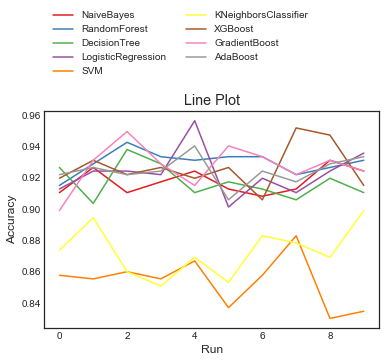

In [454]:
plt.style.use('ggplot')
plt.style.use('seaborn-white')

palette = plt.get_cmap("Set1")

for i, column in enumerate(performance_table):
    plt.plot(performance_table[column], color = palette(i), label = column)

plt.legend(loc = 2, ncol = 2, bbox_to_anchor = (0,1.5))
plt.title("Line Plot")
plt.xlabel("Run")
plt.ylabel("Accuracy")

In [455]:
performance_table.describe()

,NaiveBayes,RandomForest,DecisionTree,LogisticRegression,SVM,KNeighborsClassifier,XGBoost,GradientBoost,AdaBoost
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.917890,0.929817,0.917431,0.923165,0.853899,0.873165,0.926606,0.927523,0.924541
std,0.008077,0.007428,0.010973,0.014991,0.015966,0.016148,0.013972,0.013812,0.009203
min,0.908257,0.915138,0.903670,0.901376,0.830275,0.850917,0.905963,0.899083,0.905963
25%,0.911124,0.927179,0.910550,0.914564,0.841743,0.862385,0.919725,0.922592,0.922018
50%,0.915138,0.931193,0.915138,0.923165,0.856651,0.871560,0.924312,0.930046,0.924312
75%,0.924312,0.933486,0.924885,0.924312,0.859518,0.881881,0.930046,0.932913,0.928326
max,0.931193,0.942661,0.938073,0.956422,0.883028,0.899083,0.951835,0.949541,0.940367


Text(0, 0.5, 'Accuracy')

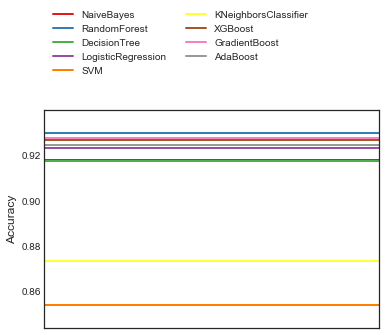

In [456]:
df = performance_table.describe()
mean_list = list(df.loc["mean", :])

palette = plt.get_cmap("Set1")

for i, mean in enumerate(mean_list):
    plt.axhline(y = mean, color = palette(i), label = models[i], linewidth = 2)
    
plt.legend(loc = 2, ncol = 2, bbox_to_anchor = (0,1.5))
plt.xticks([])
plt.ylim(min(mean_list) - 0.01, max(mean_list) + 0.01)
plt.ylabel("Accuracy")    

In [457]:
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(train[list(test.columns)], train["Survived"])
pred1 = classifier.predict(test)

classifier = GaussianNB()
classifier.fit(train[list(test.columns)], train["Survived"])
pred2 = classifier.predict(test)

classifier = DecisionTreeClassifier(random_state = 100)
classifier.fit(train[list(test.columns)], train["Survived"])
pred3 = classifier.predict(test)

classifier = XGBClassifier()
classifier.fit(train[list(test.columns)], train["Survived"])
pred4 = classifier.predict(test)

classifier = LogisticRegression(solver = "lbfgs", max_iter = 700)
classifier.fit(train[list(test.columns)], train["Survived"])
pred5 = classifier.predict(test)

classifier = SVC(gamma = "scale")
classifier.fit(train[list(test.columns)], train["Survived"])
pred6 = classifier.predict(test)

classifier = KNeighborsClassifier(p = 2, n_neighbors = 10)
classifier.fit(train[list(test.columns)], train["Survived"])
pred7 = classifier.predict(test)

classifier = GradientBoostingClassifier(n_estimators = 7, learning_rate = 1.1)
classifier.fit(train[list(test.columns)], train["Survived"])
pred8 = classifier.predict(test)

classifier = AdaBoostClassifier(n_estimators = 50, learning_rate = 1)
classifier.fit(train[list(test.columns)], train["Survived"])
pred9 = classifier.predict(test)

In [458]:
submit = pd.DataFrame(list(zip(test_temp["PassengerId"], pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9)))
submit['Survived_Sum'] = submit.loc[:, 1:].sum( axis = 1)
submit['Survived'] = np.where (submit['Survived_Sum'] > 4, 1, 0)

In [459]:
#submit.columns[0].name = 'PassengerId'
submit.columns = ['PassengerId','p1','p2','p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'Survived_Sum', 'Survived']
submit2 = submit[['PassengerId', 'Survived']]
submit2.to_csv('submission2178.csv', index = False)

In [460]:
# 0, 9는 확실하기 때문에 test 데이터에서 Train Data로 옮겨 놓고 다시 Training 하면 어떨까
submit.head()
tmpDF0 = submit[(submit['Survived_Sum'] == 0)]['PassengerId'].tolist()
tmpDF1 = submit[(submit['Survived_Sum'] == 9)]['PassengerId'].tolist()

print(len(tmpDF0), len(tmpDF1))

137 36


In [461]:
testOrg = pd.read_csv("../data/test.csv")
testOrg0 = testOrg[testOrg['PassengerId'].isin(tmpDF0)]
testOrg0['Survived'] = 0

testOrg1 = testOrg[testOrg['PassengerId'].isin(tmpDF1)]
testOrg1['Survived'] = 1

# Train Data를 불러온다
trainOrg = pd.read_csv("../data/train.csv")

# trainOrg + testOrg0 + testorg1
total = pd.concat([trainOrg, testOrg0, testOrg1])
print(trainOrg.shape, testOrg0.shape, testOrg1.shape, total.shape)

# 저장한다
total.to_csv("../data/train.csv", index = False)

(2178, 12) (137, 12) (36, 12) (2351, 12)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pas

In [462]:
#!kaggle competitions submit -c titanic -f submission3.csv -m "submission2.csv - 9 Models"